# Market Simulation

<b>Description:</b> This notebooks runs the market clearing simulation given multiple bidder objects to measure performance.

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import os

import torch
import torch.nn as nn
import torch.optim as optim

from src.dqn.DQNAgent import DQNAgent
from src.dqn.ReplayBuffer import ReplayBuffer
from src.ProbBidClearing import ProbBidClearing
from src.MarketSimulator import *

## Load Energy Storage and Price Data

In [3]:
# load storage data
ENERGY_STORAGE_DATA_PATH = (
    "./src/CAISO-EnergyStorage/src/data/ES_BIDS/CAISO_ES_BIDS.parquet"
)
STORAGE_DF = pd.read_parquet(ENERGY_STORAGE_DATA_PATH)
STORAGE_DF = STORAGE_DF.ffill()

# load day-ahead and real-time prices
DAP = pd.read_csv("./data/CAISO_DAP.csv")
RTP = pd.read_csv("./data/CAISO_RTP.csv")

# read datetime and drop duplicate data
RTP["Date"] = pd.to_datetime(RTP["Date"], format="%m/%d/%Y %I:%M:%S %p")
RTP = RTP.drop_duplicates(subset=["Date", "hub"])
DAP["Date"] = pd.to_datetime(DAP["Date"], format="%m/%d/%Y %I:%M:%S %p")
DAP = DAP.drop_duplicates(subset=["Date", "zone"])

# pivot data
DAP_pivoted = DAP.pivot(index="Date", columns="zone", values="price")
RTP_pivoted = RTP.pivot(index="Date", columns="hub", values="price")

# rename 'Date' column to 'ts'
DAP_pivoted.index.names = ["ts"]
RTP_pivoted.index.names = ["ts"]

# merge dataframes on index
CAISO_PRICES = pd.merge(DAP_pivoted, RTP_pivoted, on=["ts"], how="outer")
CAISO_PRICES = CAISO_PRICES.ffill().reset_index()

# change storage data index to ts column
STORAGE_DF = STORAGE_DF.reset_index()
STORAGE_DF = STORAGE_DF.rename(columns={"datetime": "ts"})

# merge STORAGE_DF and CAISO_PRICES on datetime
storage_df = pd.merge(CAISO_PRICES, STORAGE_DF, on=["ts"], how="outer").dropna()

# add normalized demand
storage_df["normalized_demand"] = (
    storage_df.tot_energy_rtpd
    / storage_df.tot_energy_rtpd.rolling(window=16 * 288, center=True).max()
)

storage_df = storage_df.dropna()
storage_df

,ts,PGAE,SCE,SDGE,VEA,TH_NP15,TH_SP15,TH_ZP26,tot_energy_ifm,tot_energy_ruc,...,bid_rtpd_neg_3,bid_rtpd_neg_4,bid_rtpd_neg_5,bid_rtpd_neg_6,bid_rtpd_neg_7,bid_rtpd_neg_8,bid_rtpd_neg_9,bid_rtpd_neg_10,bid_rtpd_neg_11,normalized_demand
90148,2023-06-09 00:20:00,36.50000,36.99007,37.64650,36.17257,38.93386,38.93386,38.93386,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,0.000000
90149,2023-06-09 00:25:00,36.50000,36.99007,37.64650,36.17257,36.50000,36.50000,36.50000,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,0.000000
90150,2023-06-09 00:30:00,36.50000,36.99007,37.64650,36.17257,36.50000,36.50000,36.50000,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,-0.146777
90151,2023-06-09 00:35:00,36.50000,36.99007,37.64650,36.17257,36.54614,36.54614,36.54614,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,-0.146777
90152,2023-06-09 00:40:00,36.50000,36.99007,37.64650,36.17257,36.50000,36.50000,36.50000,170.0,170.0,...,-411.2,-392.4,-490.8,-1348.0,-0.25,0.00,0.0,0.00,0.0,-0.146777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226360,2024-09-23 23:20:00,41.46547,41.75055,42.01971,40.48196,42.13150,42.45273,42.30851,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,0.046802
226361,2024-09-23 23:25:00,41.46547,41.75055,42.01971,40.48196,41.77966,42.09424,41.95124,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,0.046802
226362,2024-09-23 23:30:00,41.46547,41.75055,42.01971,40.48196,39.81464,42.21492,42.21492,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,-0.040676
226363,2024-09-23 23:35:00,41.46547,41.75055,42.01971,40.48196,39.56826,41.96240,41.96240,230.0,230.0,...,-363.0,-894.2,-360.4,-2645.0,-17.19,-1.72,0.0,-0.91,0.0,-0.040676


## Run Simulation Tests

In [4]:
# define simulation parameters
n_smart_bidders = 3 # number of each bidder types
n_honest = [0, 2, 6, 18, 54]

In [144]:
def simulate_generate_results(storage_df, min_lookback, rtp_col, dap_col, sim_length, n_smart, n_honest):
    # Build simulation
    Sim = MarketSimulator(storage_df)

    # Build Honest Bidders
    honest_bidders = []
    for n in range(n_honest):
        honest_bidders.append(HonestBidder())

    # Load trained models
    models = []
    model_labels = []
    model_path = "./models/"
    prob_label_map = {"timevarying": "Static", "meanshift": "Dynamic"}
    attitude_label_map = {"conservative": "Conservative", "risky": "Risky", "honest": "Neutral"}

    for model_file in os.listdir(model_path):
        model = pkl.load(open(model_path + model_file, "rb"))
        models.append(model)
        prob_label = prob_label_map[model_file.split("_")[0]]
        attitude_label = attitude_label_map[model_file.split("_")[-1].split(".")[0]]
        model_labels.append(prob_label + " " + attitude_label)

    print(len(honest_bidders), model_labels)

    # Run Simulation
    Sim.simulate(
        bidders=models + honest_bidders,
        min_lookback=min_lookback,
        rtp_col=rtp_col,
        dap_col=dap_col,
        max_steps=sim_length,
    )

    # Generate results dictionary
    full_results = {}
    full_results["n_smart"] = n_smart
    full_results["n_honest"] = n_honest
    for model, label in zip(models, model_labels):
        results_dict = {'profit': model.profit_hist,
                        'soc': model.soc_hist,
                        'bids': model.bid_hist,
                        'power': model.action_hist,}
        full_results[label] = results_dict

    # simulation states
    sim_results_dict = {
        'clearing_price': Sim.clearing_prices,
        'available_capacity': Sim.available_capacity,
        'demand': Sim.demand,
        'rtp': Sim.rtp,
    }
    full_results['sim_results'] = sim_results_dict

    # honest bidder results
    if n_honest > 0:
        # Generate results dictionary for honest bidders (calculate mean + std)
        results_dict = {'profit': np.mean([b.profit_hist for b in honest_bidders[:n_honest]], axis=0),
                        'soc': np.mean([b.soc_hist for b in honest_bidders[:n_honest]], axis=0),
                        'bids': np.mean([b.bid_hist for b in honest_bidders[:n_honest]], axis=0),
                        'power': np.mean([b.action_hist for b in honest_bidders[:n_honest]], axis=0)}
        full_results['Honest'] = results_dict

    return full_results

In [145]:
results = []
for honest_count in n_honest:
    results.append(simulate_generate_results(storage_df, 1, "TH_NP15", "PGAE", 365 * 288, n_smart_bidders, honest_count))

0 ['Dynamic Conservative', 'Dynamic Neutral', 'Dynamic Risky', 'Static Conservative', 'Static Neutral', 'Static Risky']
2 ['Dynamic Conservative', 'Dynamic Neutral', 'Dynamic Risky', 'Static Conservative', 'Static Neutral', 'Static Risky']
6 ['Dynamic Conservative', 'Dynamic Neutral', 'Dynamic Risky', 'Static Conservative', 'Static Neutral', 'Static Risky']
18 ['Dynamic Conservative', 'Dynamic Neutral', 'Dynamic Risky', 'Static Conservative', 'Static Neutral', 'Static Risky']
54 ['Dynamic Conservative', 'Dynamic Neutral', 'Dynamic Risky', 'Static Conservative', 'Static Neutral', 'Static Risky']


## Simulation Result Analysis

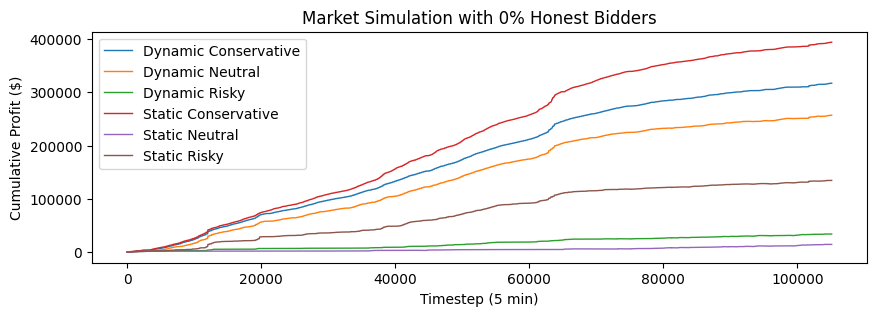

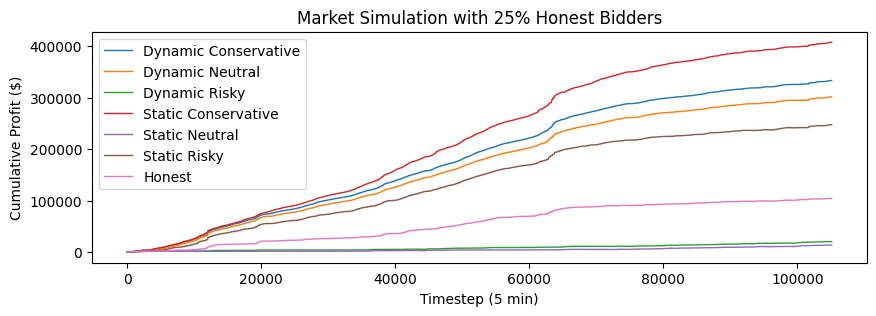

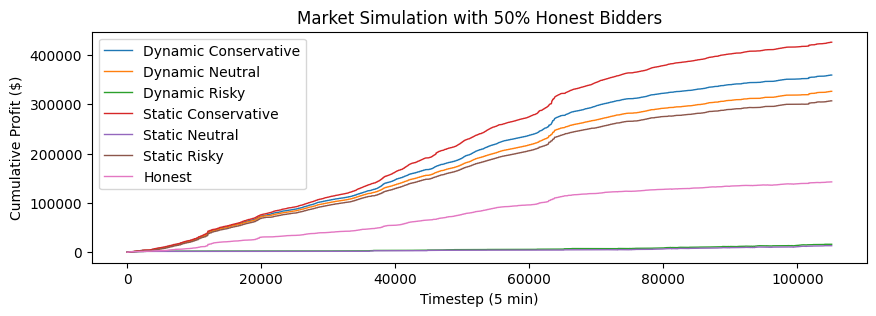

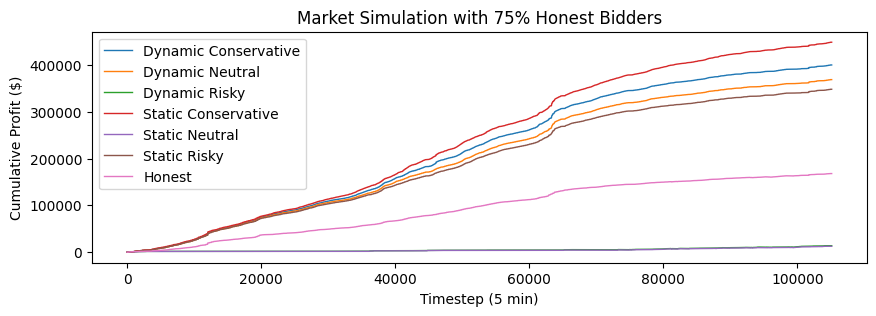

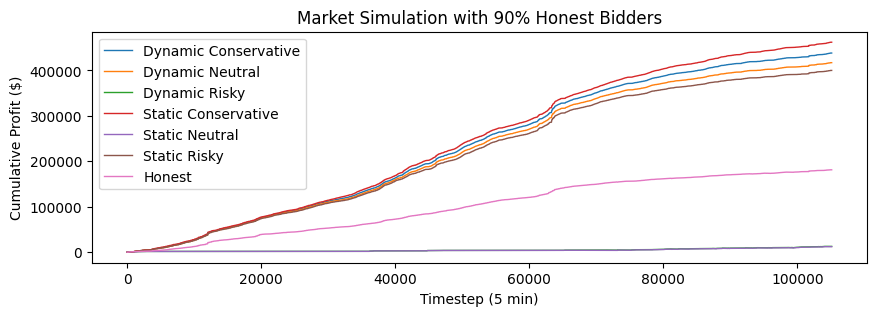

In [146]:
# Cumulative Profit
for honest_count, result in zip(n_honest, results):    
    plt.figure(figsize=(10, 3))
    for label in result.keys():
        if label in ['n_smart', 'n_honest', 'sim_results']:
            continue
        plt.plot(np.cumsum(result[label]['profit']), label=label, linewidth=1)
    plt.ylabel("Cumulative Profit ($)")
    plt.xlabel("Timestep (5 min)")
    plt.title(f"Market Simulation with {int((100 * honest_count) / (honest_count + 6))}% Honest Bidders")
    plt.legend()
    plt.show()

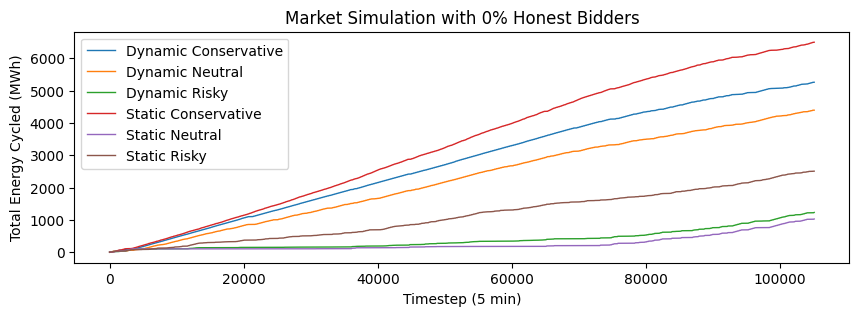

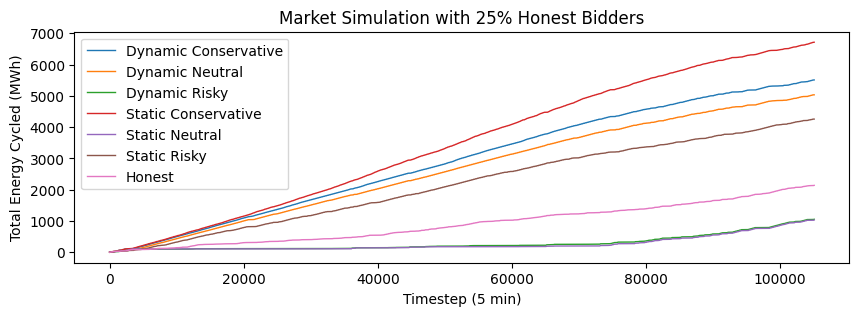

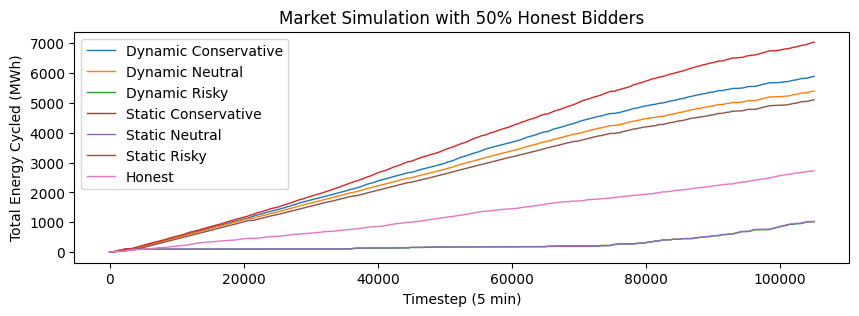

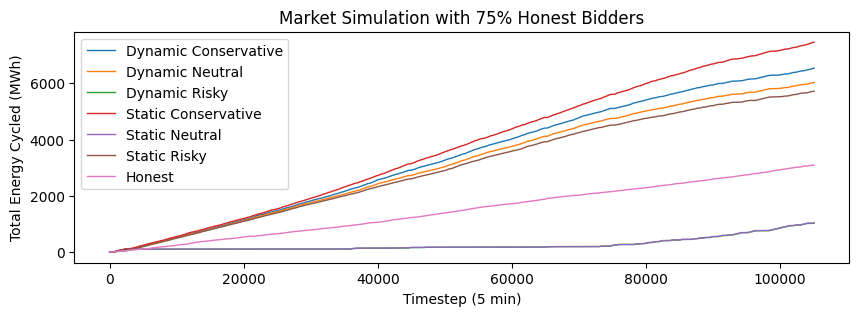

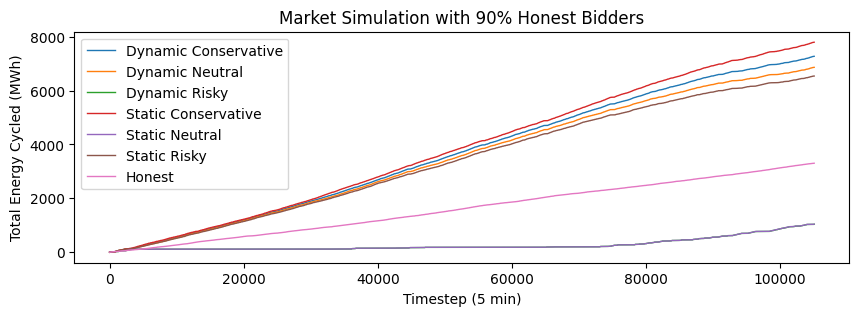

In [147]:
# total energy cycled
for honest_count, result in zip(n_honest, results):    
    plt.figure(figsize=(10, 3))
    for label in result.keys():
        if label in ['n_smart', 'n_honest', 'sim_results']:
            continue
        plt.plot(np.cumsum(np.abs(result[label]['power'])) / 12., label=label, linewidth=1)
    plt.ylabel("Total Energy Cycled (MWh)")
    plt.xlabel("Timestep (5 min)")
    plt.title(f"Market Simulation with {int((100 * honest_count) / (honest_count + 6))}% Honest Bidders")
    plt.legend()
    plt.show()

C:\Users\Astro\AppData\Local\Temp\ipykernel_29072\1636768085.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


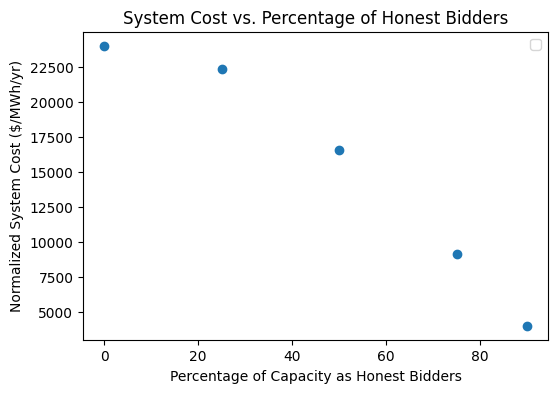

In [148]:
# average system price vs. percentage of honest bidders 
plt.figure(figsize=(6, 4))
honest_percentages = []
total_system_costs = []
total_capacity = []
for honest_count, result in zip(n_honest, results):
    tot_cost = 0.0
    for label in result.keys():
        if label in ['n_smart', 'n_honest', 'sim_results']:
            continue
        tot_cost += np.sum(result[label]['profit'])
    honest_percentages.append(int((100 * honest_count) / (honest_count + 6)))
    total_system_costs.append(tot_cost)
    total_capacity.append((6 + honest_count) * 8)
plt.scatter(honest_percentages, np.array(total_system_costs) / np.array(total_capacity), linewidth=1)
plt.ylabel("Normalized System Cost ($/MWh/yr)")
plt.xlabel("Percentage of Capacity as Honest Bidders")
plt.title(f"System Cost vs. Percentage of Honest Bidders")
plt.legend()
plt.show()

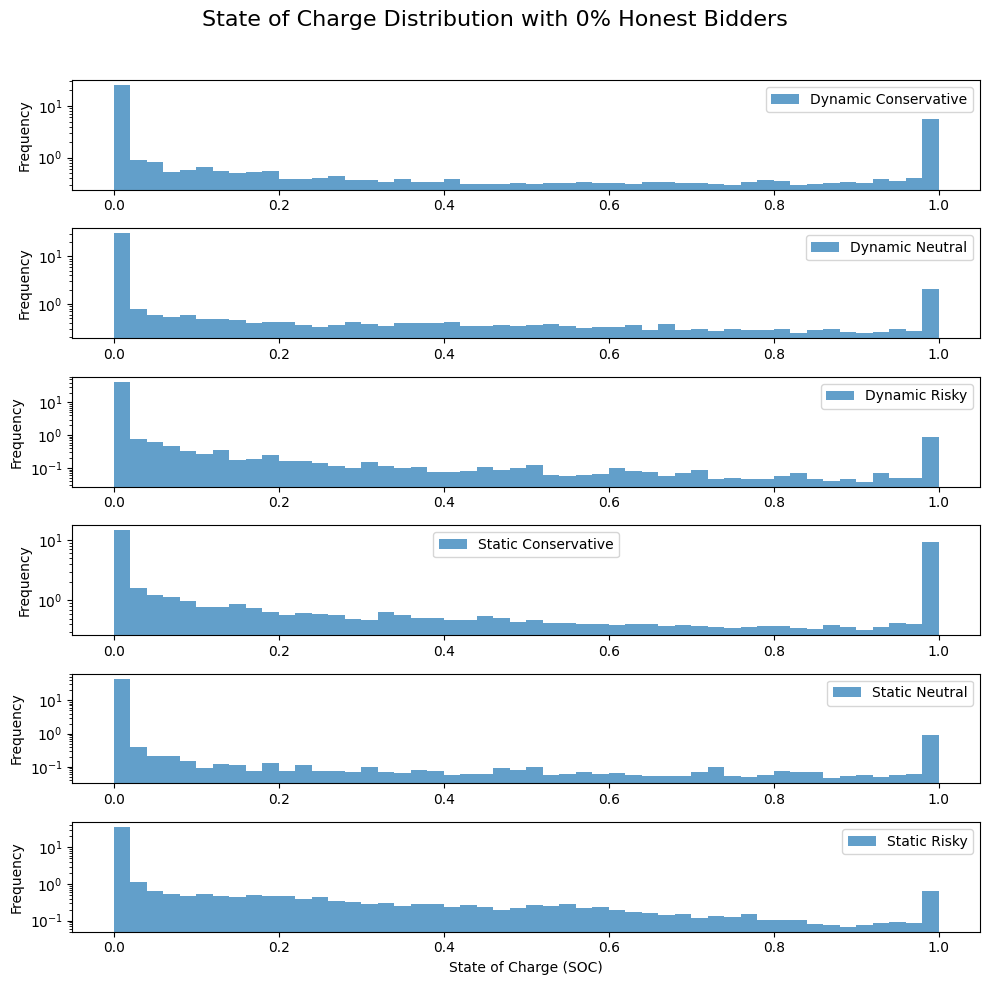

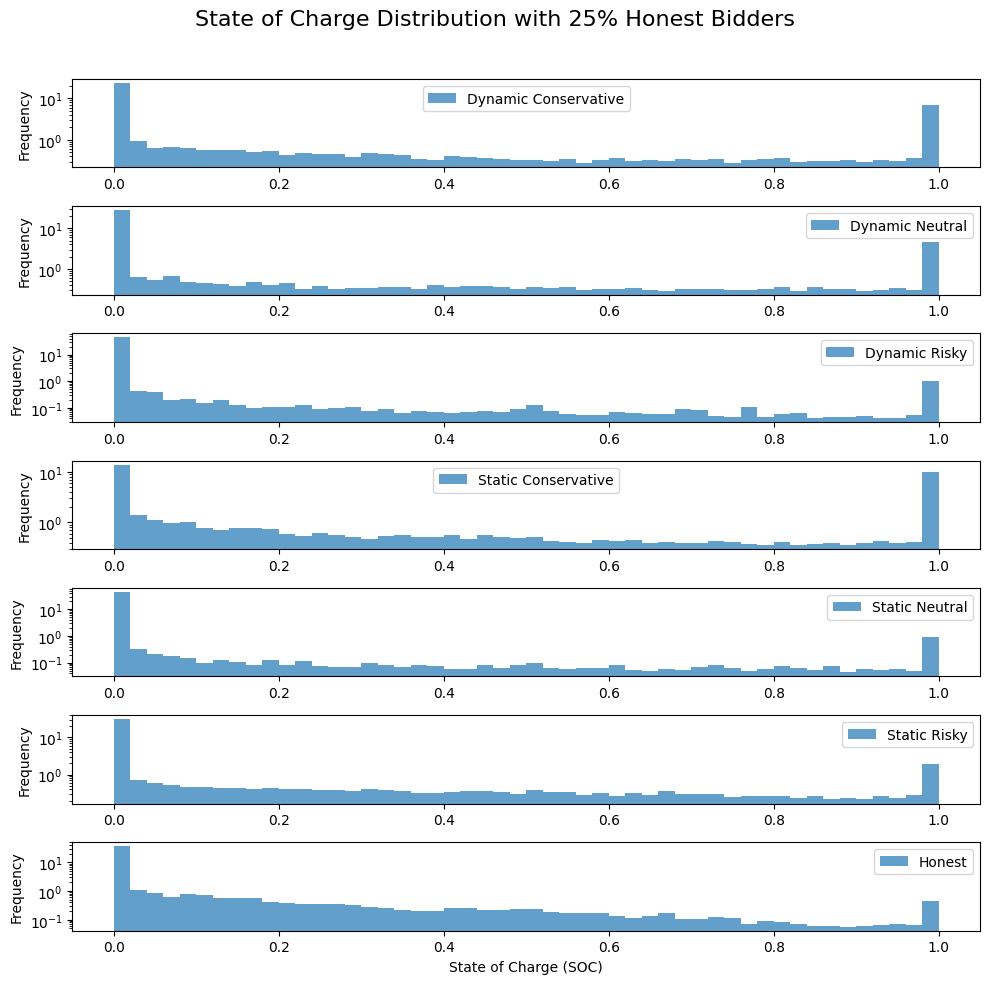

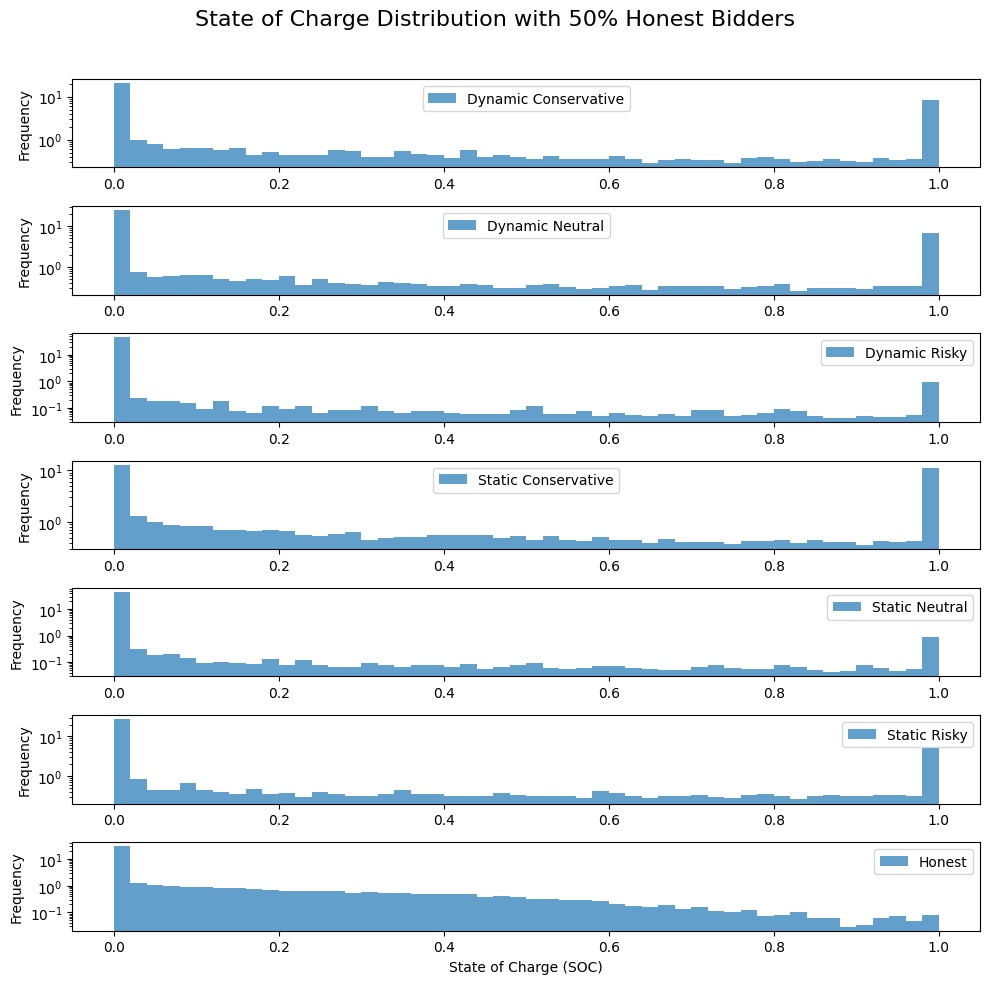

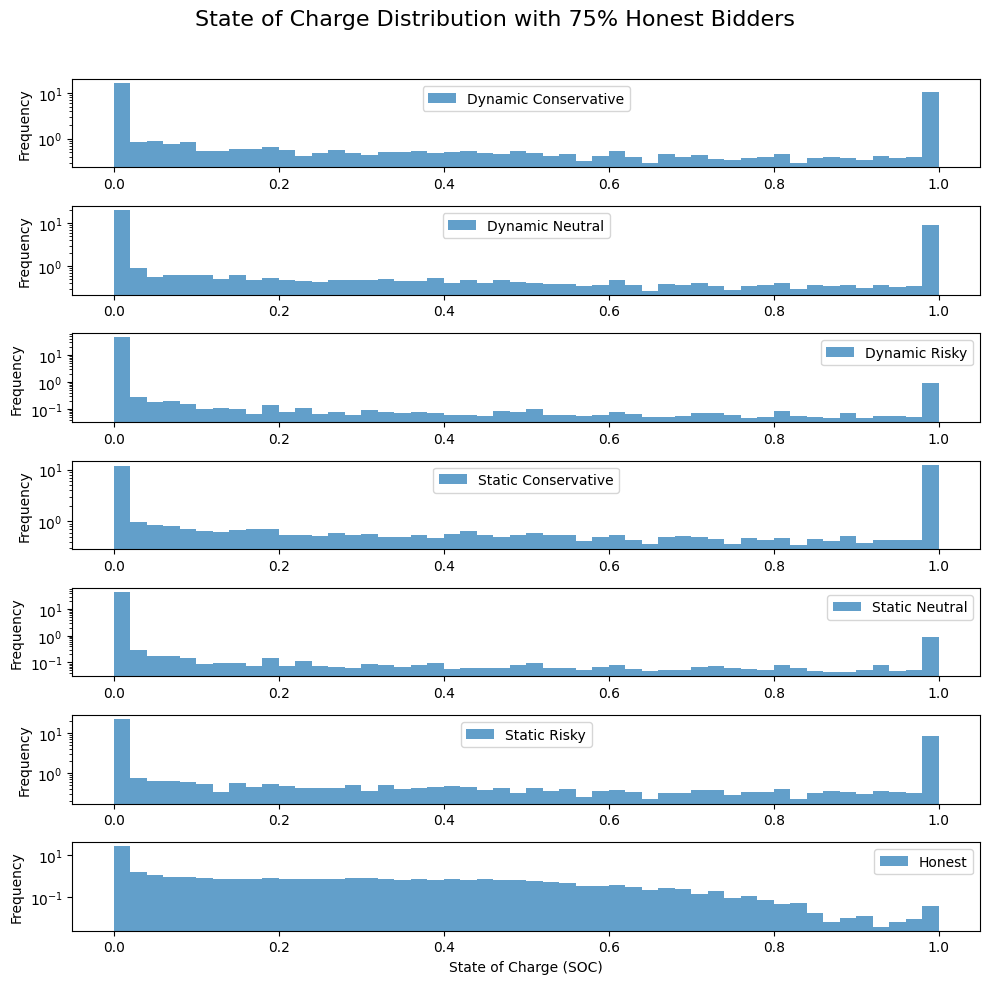

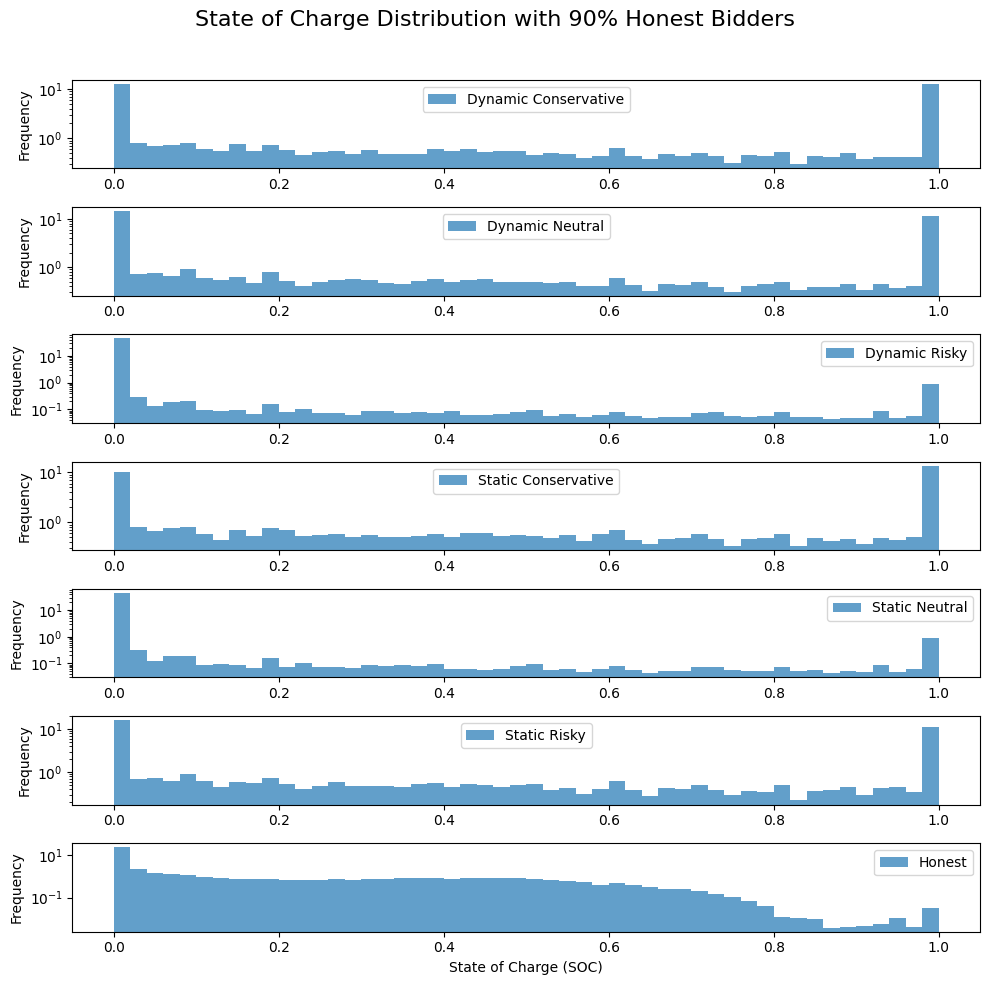

In [149]:
for honest_count, result in zip(n_honest, results):
    num_plots = 6 if honest_count == 0 else 7
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 10))
    fig.suptitle(f"State of Charge Distribution with {int((100 * honest_count) / (honest_count + 6))}% Honest Bidders", fontsize=16)
    
    plot_index = 0
    for label in result.keys():
        if label in ['n_smart', 'n_honest', 'sim_results']:
            continue
        axes[plot_index].hist(result[label]['soc'], bins=50, alpha=0.7, label=label, density=True)
        axes[plot_index].set_ylabel("Frequency")
        axes[plot_index].set_yscale("log")
        if plot_index == num_plots - 1:
            axes[plot_index].set_xlabel("State of Charge (SOC)")
        axes[plot_index].legend()
        plot_index += 1
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

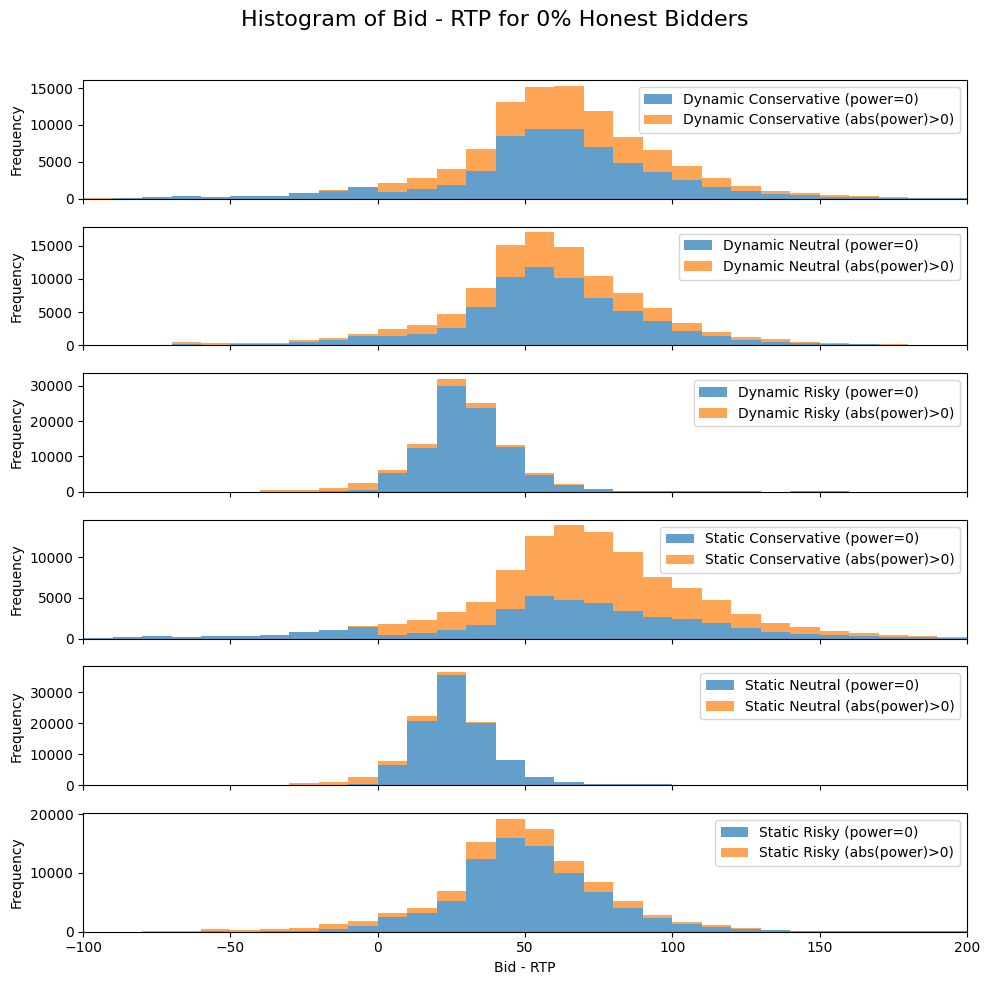

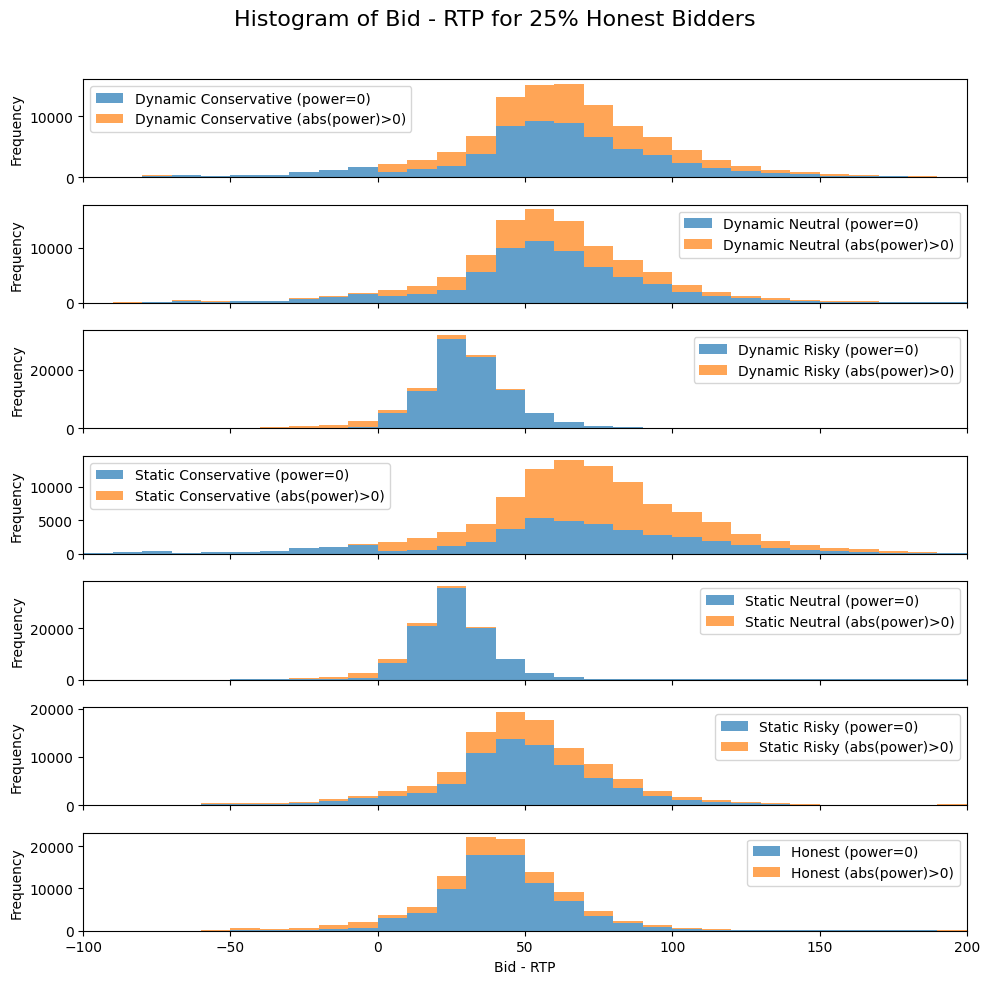

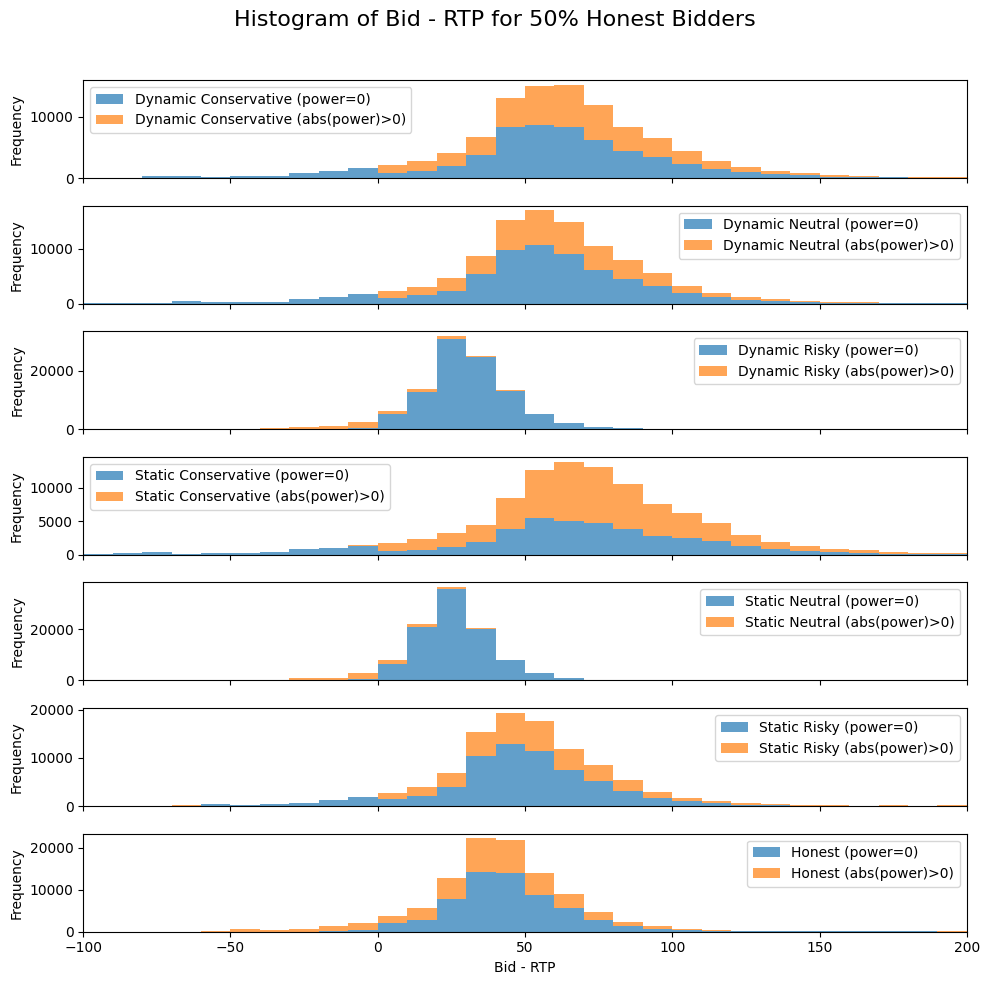

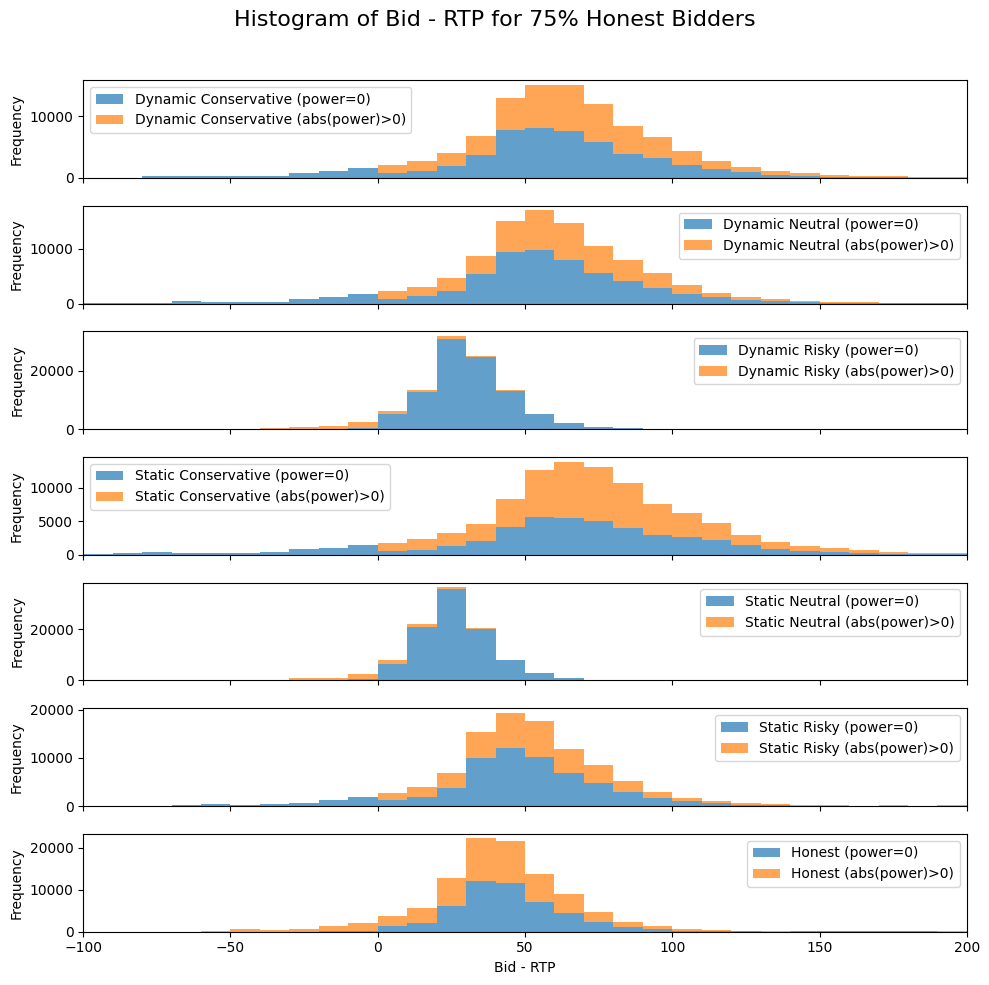

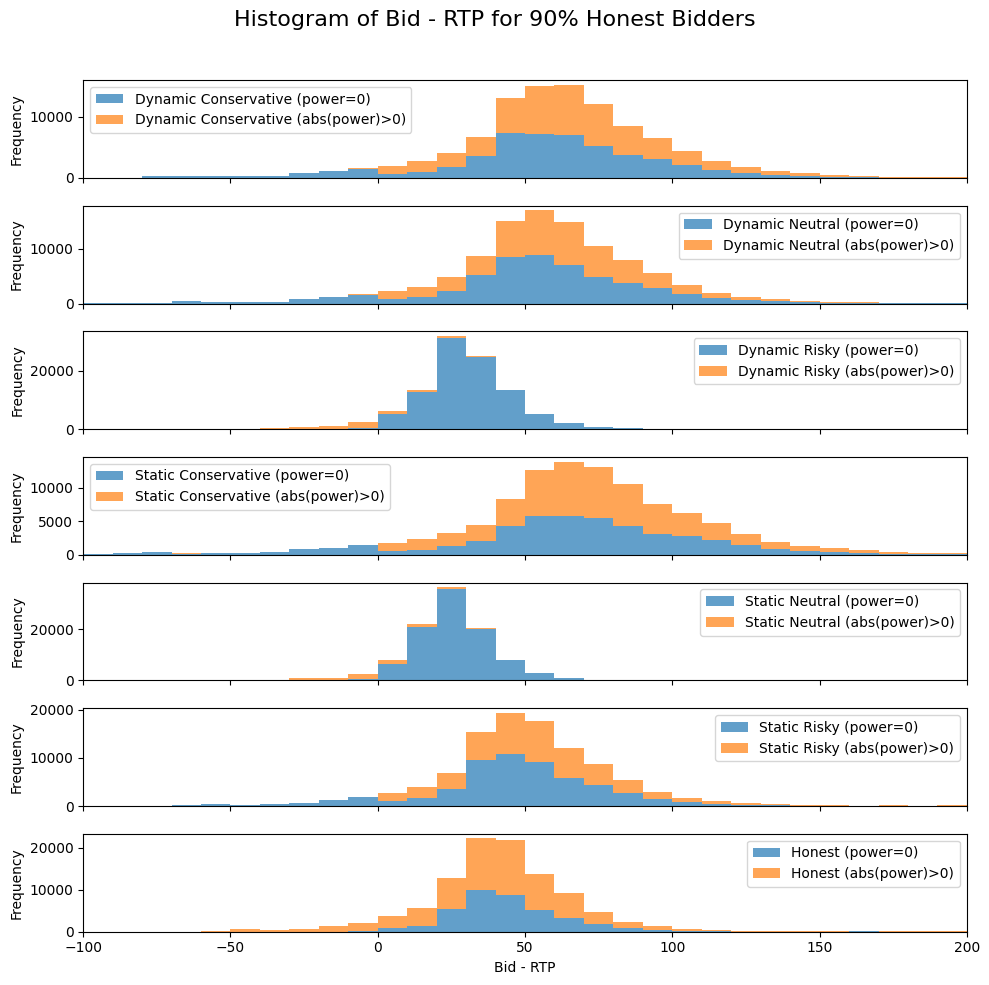

In [150]:
for honest_count, result in zip(n_honest, results):
    num_plots = 6 if honest_count == 0 else 7
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(f"Histogram of Bid - RTP for {int((100 * honest_count) / (honest_count + 6))}% Honest Bidders", fontsize=16)
    
    plot_index = 0
    for label in result.keys():
        if label in ['n_smart', 'n_honest', 'sim_results']:
            continue
        bid_minus_rtp = np.array(result[label]['bids']) - np.array(result[label]['power'])
        power = np.array(result[label]['power'])
        
        # Condition for power > 0 and power = 0
        power_non_zero = bid_minus_rtp[abs(power) > 0]
        power_zero = bid_minus_rtp[power == 0]
        
        axes[plot_index].hist([power_zero, power_non_zero], bins=np.linspace(-100, 200, 31), stacked=True, label=[f'{label} (power=0)', f'{label} (abs(power)>0)'], alpha=0.7)
        axes[plot_index].set_ylabel("Frequency")
        if plot_index == num_plots - 1:
            axes[plot_index].set_xlabel("Bid - RTP")
        
        # Set x-lim from minimum value to 99th percentile value of bid-rtp
        min_value = bid_minus_rtp.min()
        percentile_99 = np.percentile(bid_minus_rtp, 99)
        axes[plot_index].set_xlim(-100, 200)
        # axes[plot_index].set_xlim(min_value, percentile_99)
        
        axes[plot_index].legend()
        plot_index += 1
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

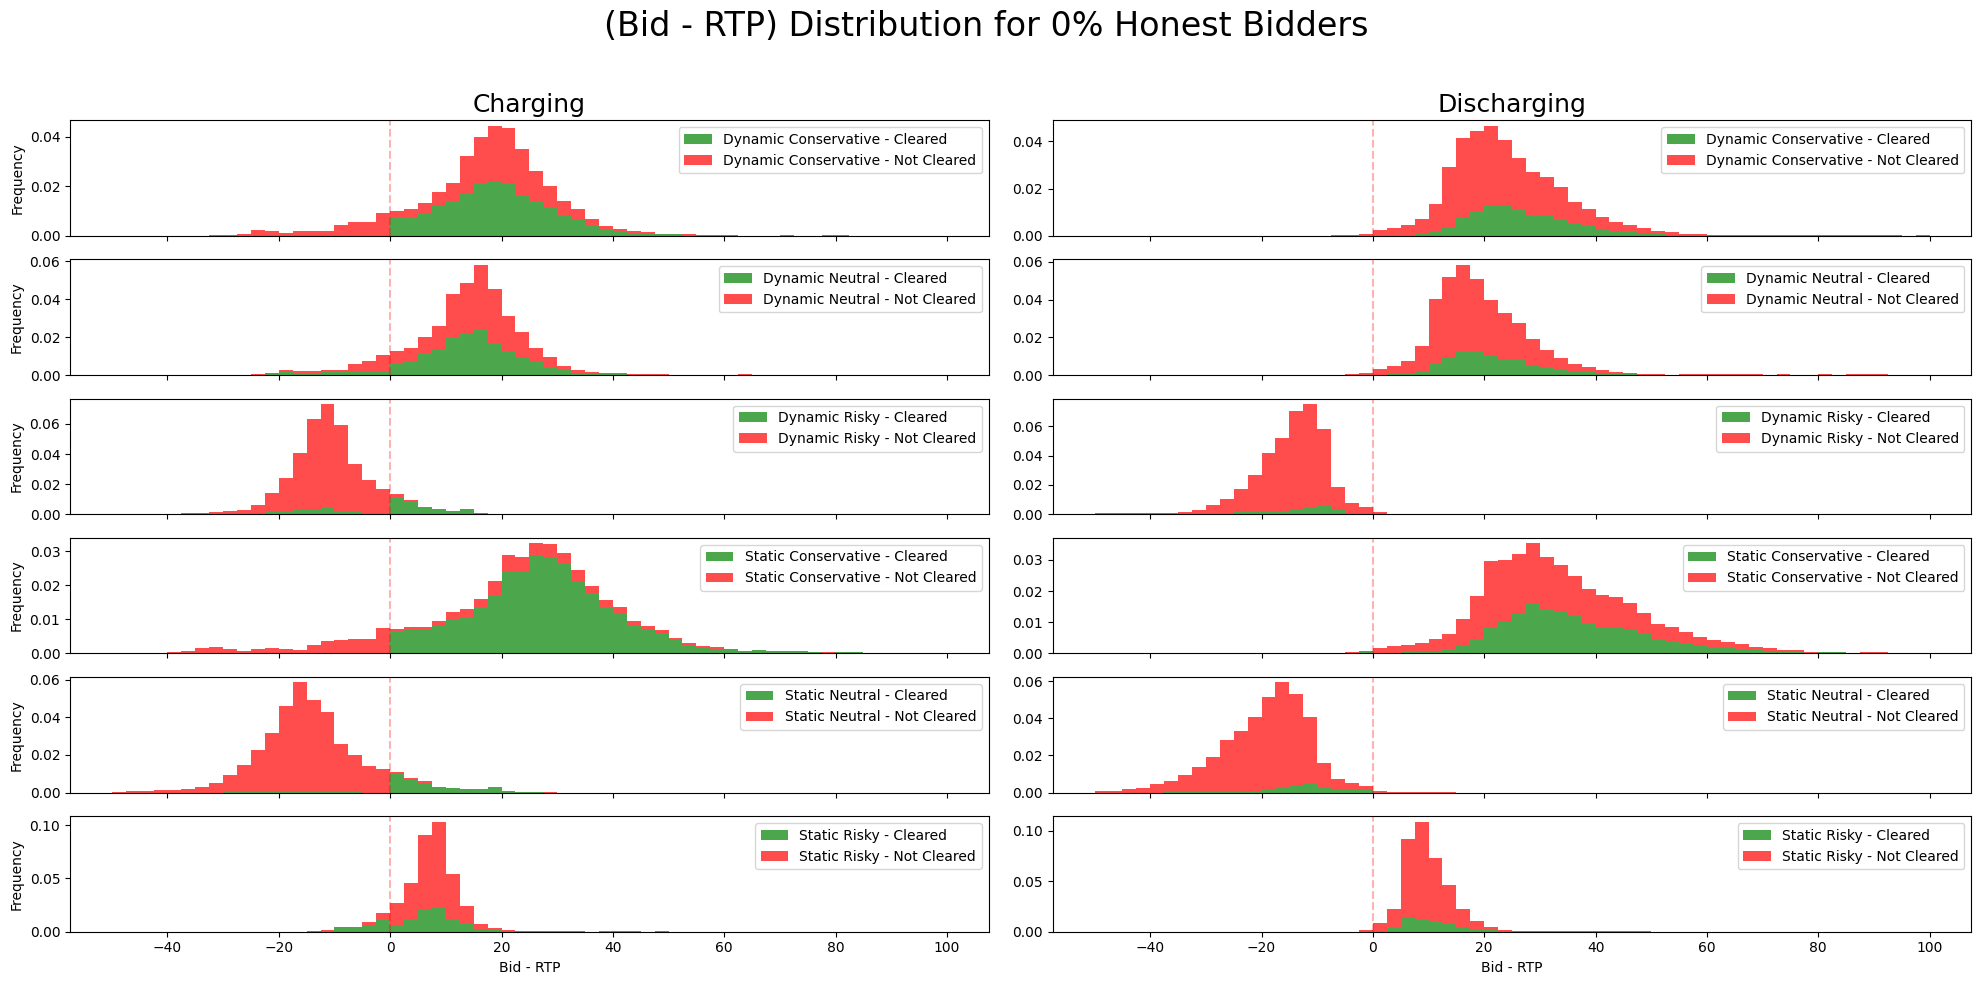

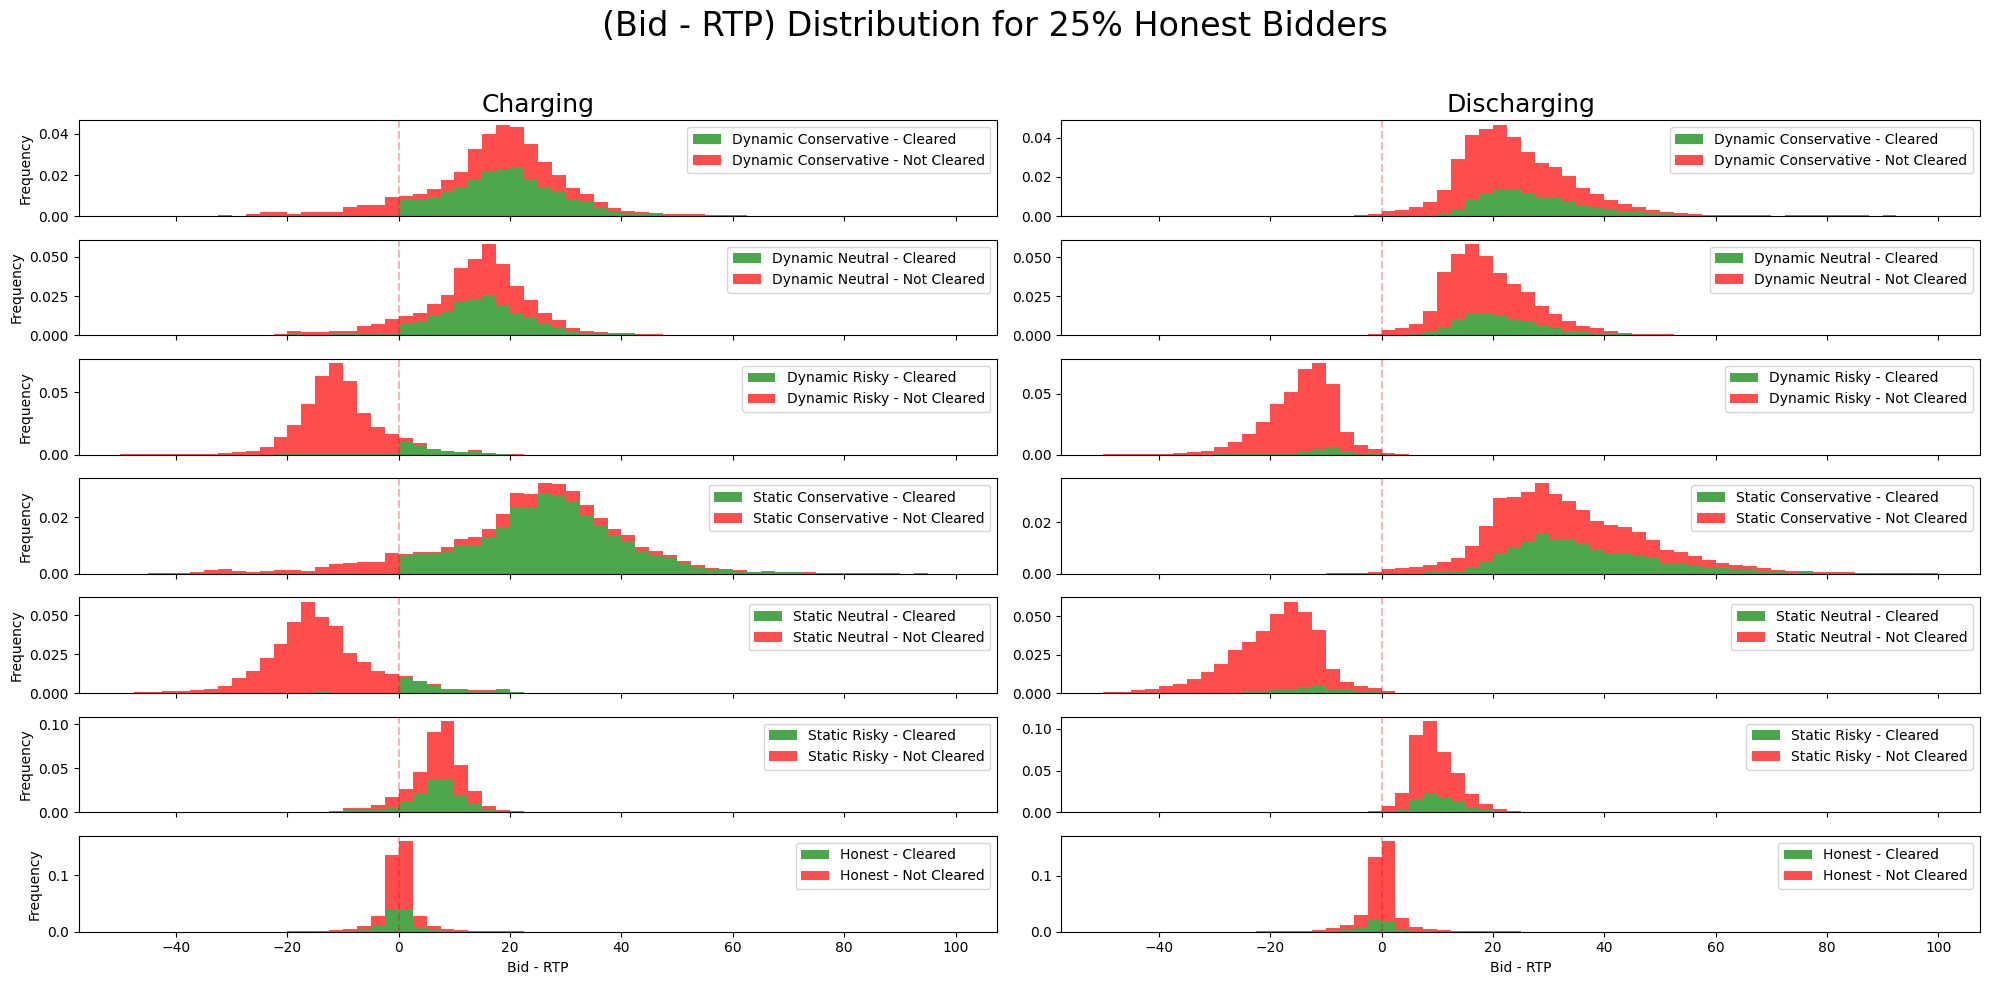

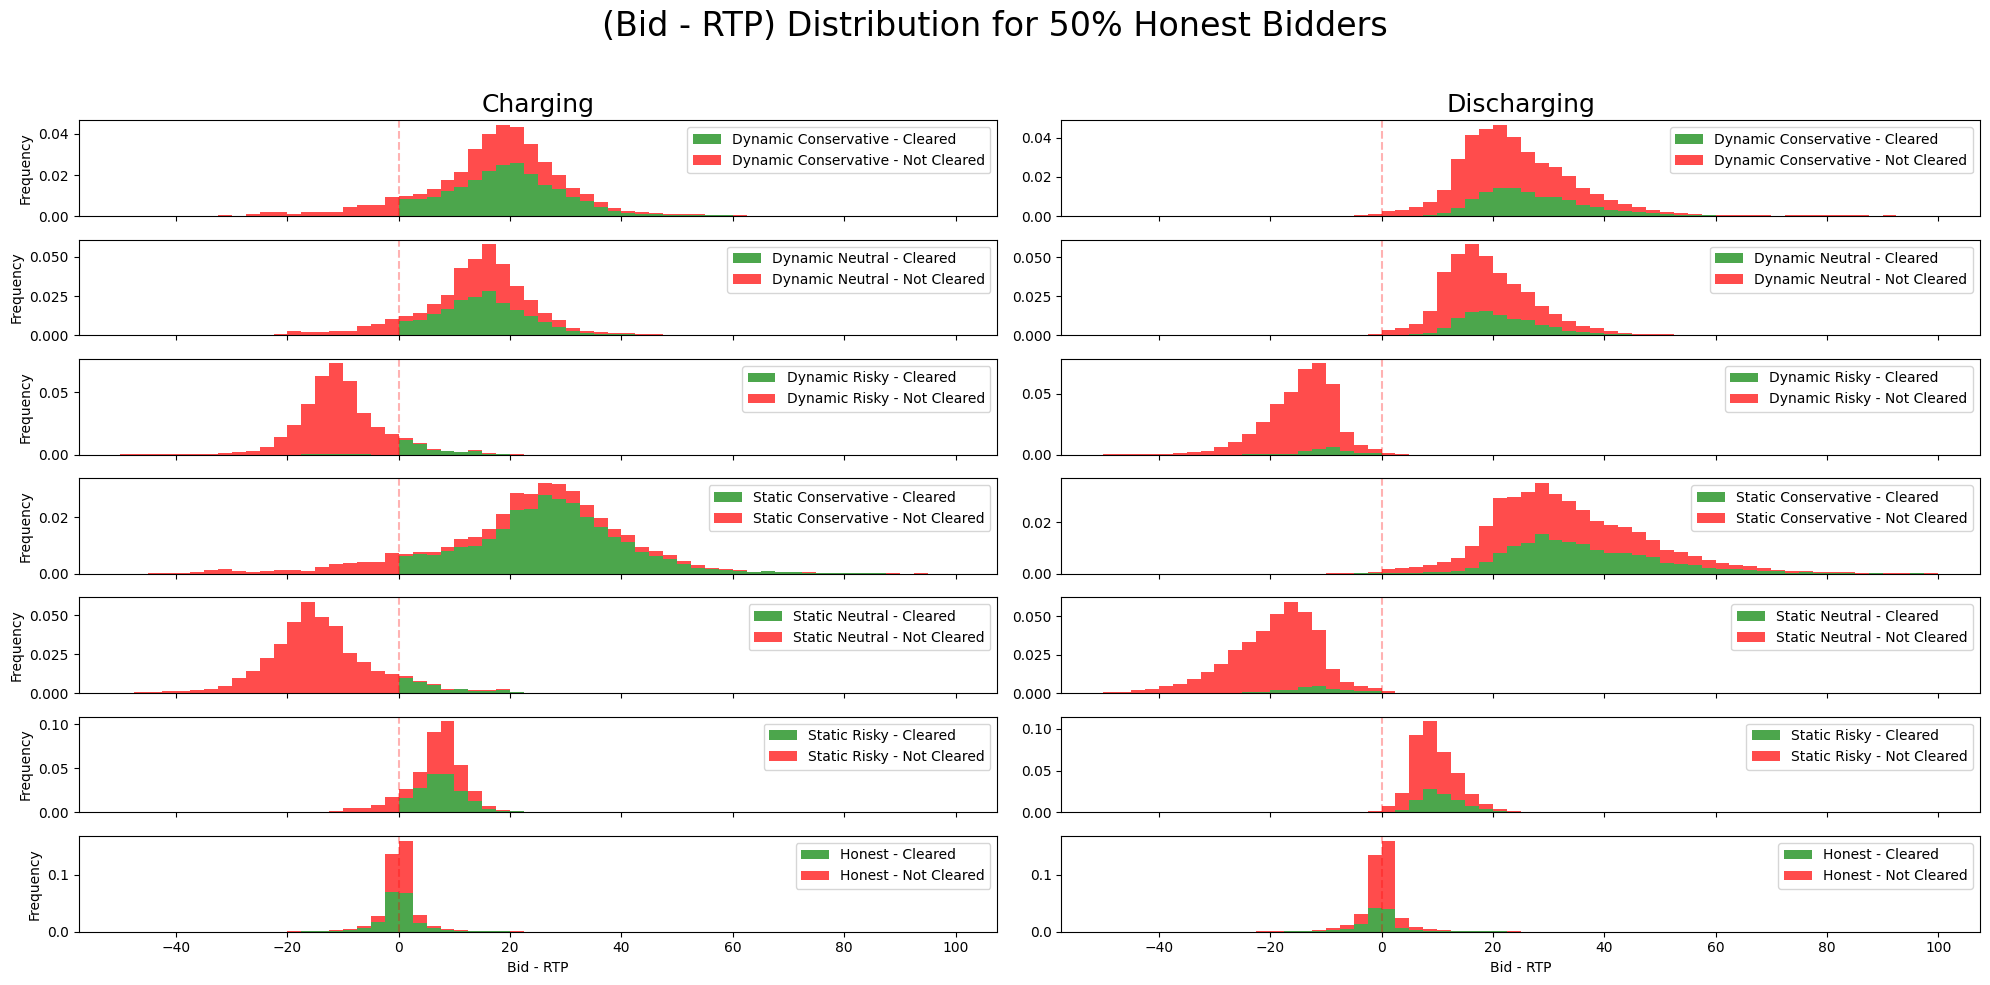

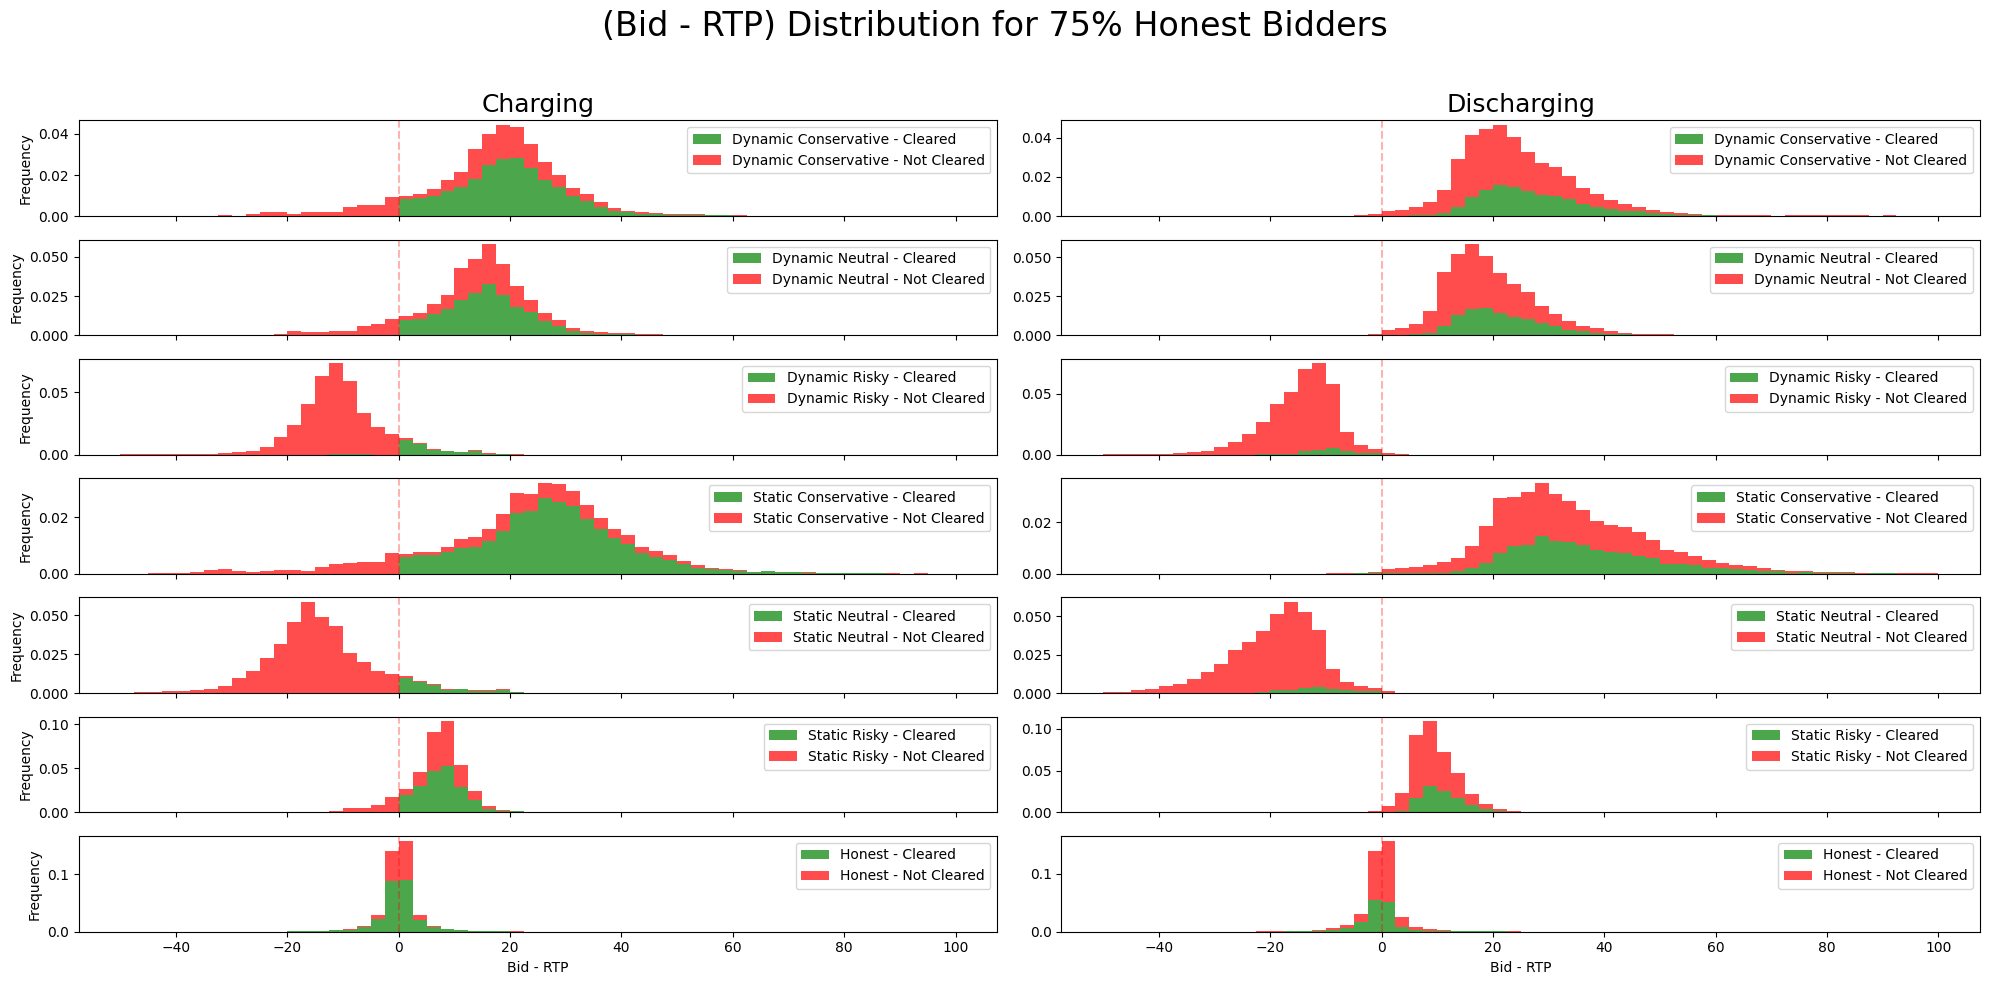

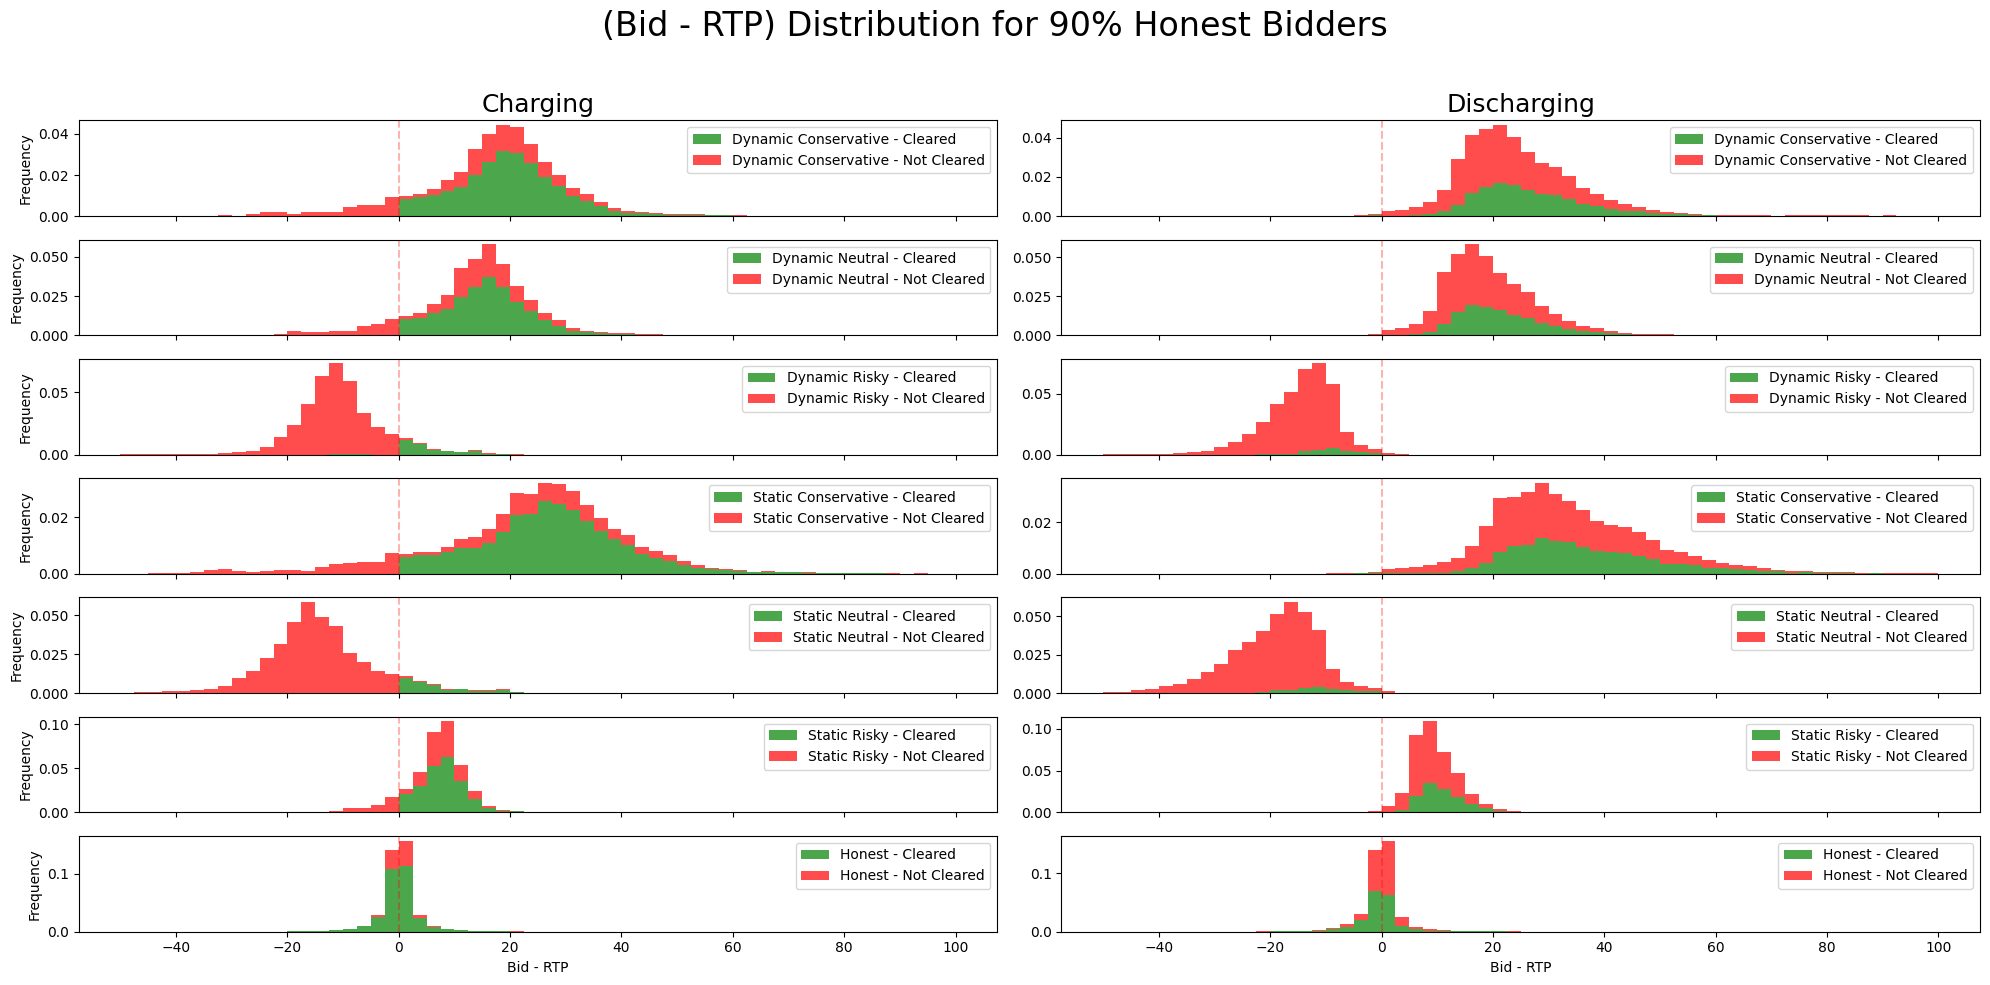

In [151]:
for honest_count, result in zip(n_honest, results):
    num_plots = 6 if honest_count == 0 else 7
    fig, axes = plt.subplots(num_plots, 2, figsize=(20, 10), sharex=True)
    fig.suptitle(f"(Bid - RTP) Distribution for {int((100 * honest_count) / (honest_count + 6))}% Honest Bidders", fontsize=24)
    
    plot_index = 0
    for label in result.keys():
        if label in ['n_smart', 'n_honest', 'sim_results']:
            continue
        power = np.array(result[label]['power'])
        demand = np.array(storage_df[:len(result[label]['bids'])]['normalized_demand'])
        rtp = storage_df['TH_NP15'][:len(result[label]['bids'])]
        bid_minus_rtp = np.array(result[label]['bids']) - np.array(rtp)
        
        # Condition for power > 0 and power = 0
        power_non_zero = bid_minus_rtp[abs(power) > 0]
        power_zero = bid_minus_rtp[power == 0]
        
        # Split data based on demand
        bid_minus_rtp_demand_neg = bid_minus_rtp[:len(result[label]['bids'])][demand < 0]
        bid_minus_rtp_demand_pos = bid_minus_rtp[:len(result[label]['bids'])][demand > 0]
        power_non_zero_demand_neg = power_non_zero[:len(result[label]['bids'])][demand[abs(power) > 0] < 0]
        power_non_zero_demand_pos = power_non_zero[:len(result[label]['bids'])][demand[abs(power) > 0] > 0]
        power_zero_demand_neg = power_zero[:len(result[label]['bids'])][demand[power == 0] < 0]
        power_zero_demand_pos = power_zero[:len(result[label]['bids'])][demand[power == 0] > 0]
        
        # Plot for demand < 0
        axes[plot_index, 0].hist([power_non_zero_demand_neg, power_zero_demand_neg], bins=np.linspace(-50, 100, 61), stacked=True, label=[f'{label} - Cleared', f'{label} - Not Cleared'], color=['g', 'r'], alpha=0.7, density=True)
        axes[plot_index, 0].set_ylabel("Frequency")
        axes[plot_index, 0].axvline(x=0, color='red', linestyle='--', alpha=0.3)  # Add vertical red dashed line at x=0
        axes[plot_index, 0].legend()
        if plot_index == num_plots - 1:
            axes[plot_index, 0].set_xlabel("Bid - RTP")
        
        # Plot for demand > 0
        axes[plot_index, 1].hist([power_non_zero_demand_pos, power_zero_demand_pos], bins=np.linspace(-50, 100, 61), stacked=True, label=[f'{label} - Cleared', f'{label} - Not Cleared'], color=['g', 'r'], alpha=0.7, density=True)
        axes[plot_index, 1].axvline(x=0, color='red', linestyle='--', alpha=0.3)  # Add vertical red dashed line at x=0
        if plot_index == num_plots - 1:
            axes[plot_index, 1].set_xlabel("Bid - RTP")
        axes[plot_index, 1].legend()
        
        plot_index += 1
    axes[0, 0].set_title("Charging", fontsize=18)
    axes[0, 1].set_title("Discharging", fontsize=18)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

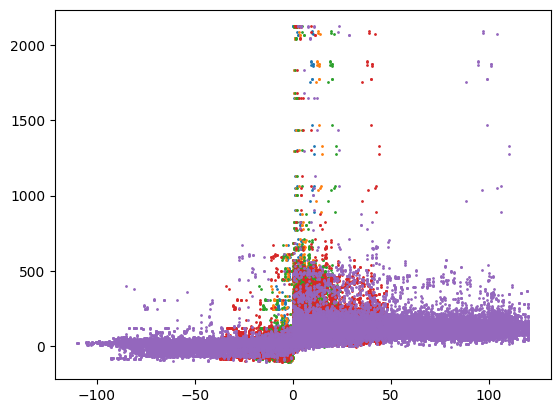

In [156]:
for honest_count, result in zip(n_honest, results):
    plt.scatter(result['sim_results']['demand'], result['sim_results']['clearing_price'], s=1)
    # plt.show()